# ta-lib-008 ( Feature‑Engineering + Sequence Models)
https://chatgpt.com/c/680d231a-52f4-800a-a105-9f5bfe49fca1

What's new:

1-

# Load your historical Forex data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

2025-05-06 16:22:01.055738: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# PARAMETERS
MODEL_SAVE_PATH = 'lstm_forex_model.h5'
WINDOW_SIZE = 30  # Number of past candles used as input
FORECAST_HORIZON = 10  # Number of future candles to predict
LEARNING_RATE = 0.001

In [3]:

df = pd.read_csv('datasets/XAGUSD-H1-rates.csv', sep='\t')

# Basic cleaning if necessary
df = df.dropna()

# Scaling Features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']])


def create_sequences(features, target, window_size, forecast_horizon):
    X, y = [], []
    for i in range(window_size, len(features) - forecast_horizon):
        X.append(features[i - window_size:i])
        y.append(target[i:i + forecast_horizon])
    return np.array(X), np.array(y)


# Prepare data
target_data = df['<CLOSE>'].values
X, y = create_sequences(scaled_features, target_data, WINDOW_SIZE, FORECAST_HORIZON)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


def build_model(input_shape, forecast_horizon, learning_rate):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(forecast_horizon)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model


model = build_model((X_train.shape[1], X_train.shape[2]), FORECAST_HORIZON, LEARNING_RATE)
# Training model
history = model.fit(
    X_train, y_train,
    epochs=1,
    verbose=1,
)
# Predict
y_pred = model.predict(X_test)


/home/saeed/repozitories/machine-learning/forex-prediction/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1377/1377 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - loss: 123.8826
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


# plot section

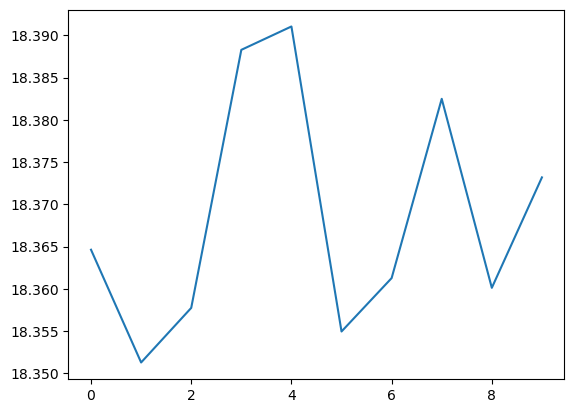

In [4]:
plt.plot(range(10), y_pred[0])
plt.show()


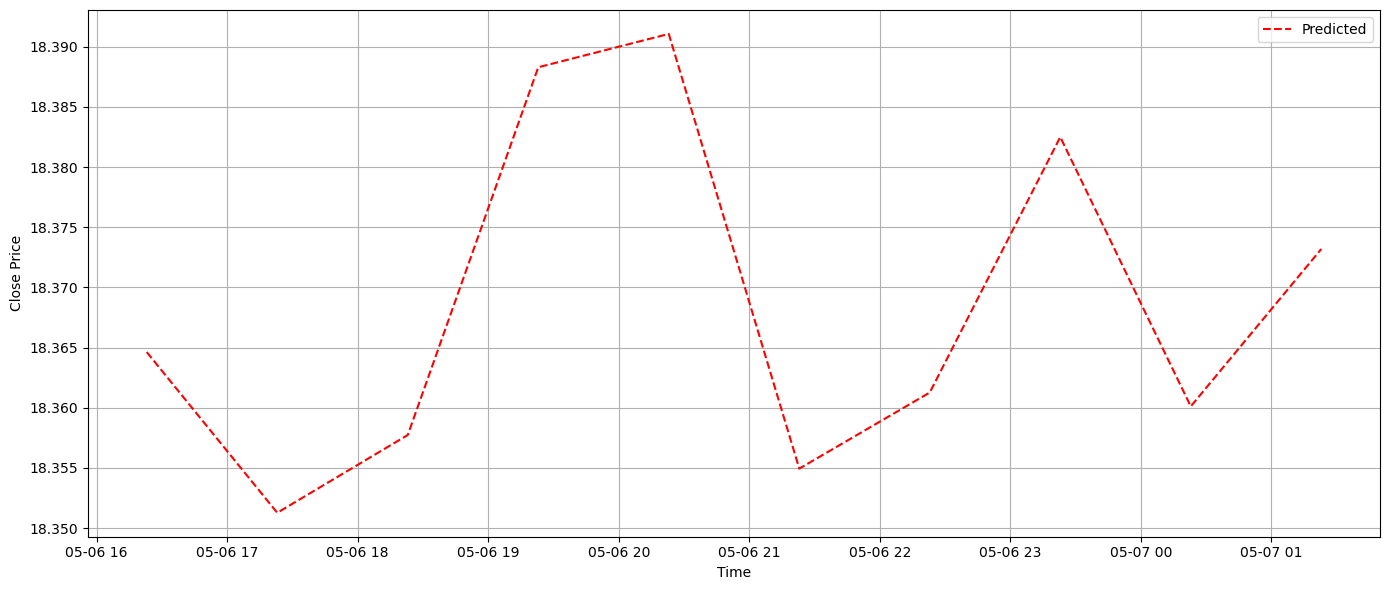

In [5]:
from utils import forex_plot_utils
from datetime import datetime

# LOAD DATA
start_time = datetime.now()

# Create datetime index starting from now, one per hour
datetime_index = pd.date_range(start=start_time, periods=len(y_pred[0]), freq='h')

# Create DataFrame
predicted_df = pd.DataFrame({'DATETIME': datetime_index, '<CLOSE>': y_pred[0]})

# PLOT
forex_plot_utils.plot_all_series(
    predicted_df=predicted_df,
)